# Final Project, IS 620

## Ranking Centrality of Senators and Bills

In this script, we will rank the centrality of senators and bills associated with the 115th Congress of the United States of America.  We define centrality in terms of the number of links via bill sponsorship.  For example, a bill could be considered more highly central if it has 20 cosponsors rather than a single sponsor.  A senator could be considered more central if s/he is linked to 20 other senators via cosponsoring bills with them, rather than not sponsoring bills with anyone else.

Note that this kind of centrality measure is not taking into account very significant elements of senatorial influence:

* length of time in office
* being a junior or senior rank within the state
* membership in key committees
* amount of press coverage
* approval ratings
* etc.

We are simply ranking senators by prolificness -- how much are different senators contributing to the senate's legislative docket? Also, it's helpful to note that many bills are actually committee bills and therefore are introduced under the name of the (sub)committee's chairperson as a formality.

Similarly, bills could have their relative importance measured by a number of factors we're intentionally leaving out -- things like

* the amount of press coverage received
* the likelihood of passage
* its economic impact
* etc.

Note that while we're analyzing bills, we will also go ahead and measure their partisanship -- how balanced the democratic and republican support for each bill is.  This will allow us to optionally analyze bills as well on their partisan nature to detect if there are any discernible differences in the language of strongly left-leaning or right-leaning bills.

## Import Needed Packages

In [1]:
import requests
import json
import networkx as net
import networkx.algorithms.bipartite as bipartite
import pandas as pd
import time
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

## Set Up Function to Use ProPublica Congress API

In [2]:
def propublica(url):
    r = requests.get(url, headers={'X-API-Key': '***REDACTED***'})  
    data = json.loads(r.text)
    return (data)

## Get List of Senators from Propublica API

In [3]:
senators = propublica("https://api.propublica.org/congress/v1/115/senate/members.json")['results'][0]['members']
senators[:] = [d for d in senators if d.get('last_name') != 'Sessions']  # Jeff Sessions no longer Senator
senators[:] = [d for d in senators if d.get('last_name') != 'Franken']   # Al Franken no longer Senator
df_senators = pd.DataFrame(senators)
df_senators.head()

,api_uri,contact_form,crp_id,cspan_id,date_of_birth,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,...,state_rank,suffix,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
0,https://api.propublica.org/congress/v1/members...,http://www.alexander.senate.gov/public/index.c...,N00009888,5,1940-07-03,0.323,senatorlamaralexander,202-228-3398,S2TN00058,Lamar,...,senior,None,"Senator, 2nd Class",0,317,SenAlexander,https://www.alexander.senate.gov/public/,98.03,15691,lamaralexander
1,https://api.propublica.org/congress/v1/members...,https://www.baldwin.senate.gov/feedback,N00004367,57884,1962-02-11,-0.546,TammyBaldwin,202-225-6942,S2WI00219,Tammy,...,junior,None,"Senator, 1st Class",1,317,SenatorBaldwin,https://www.baldwin.senate.gov/,96.21,3470,witammybaldwin
2,https://api.propublica.org/congress/v1/members...,https://www.barrasso.senate.gov/public/index.c...,N00006236,1024777,1952-07-21,0.528,johnbarrasso,202-224-1724,S6WY00068,John,...,junior,None,"Senator, 1st Class",0,317,SenJohnBarrasso,https://www.barrasso.senate.gov/,98.42,52662,barrassowyo
3,https://api.propublica.org/congress/v1/members...,https://www.bennet.senate.gov/?p=contact,N00030608,1031622,1964-11-28,-0.208,senbennetco,202-228-5097,S0CO00211,Michael,...,senior,None,"Senator, 3rd Class",1,317,SenBennetCo,https://www.bennet.senate.gov/,92.72,110942,SenatorBennet
4,https://api.propublica.org/congress/v1/members...,https://www.blumenthal.senate.gov/contact/,N00031685,21799,1946-02-13,-0.418,SenBlumenthal,202-224-9673,S0CT00177,Richard,...,senior,None,"Senator, 3rd Class",1,317,SenBlumenthal,https://www.blumenthal.senate.gov/,92.09,1568,SenatorBlumenthal


## Get Recent Active Bills

The API will only send 20 at a go, so we have to paginate!

In [4]:
url = "https://api.propublica.org/congress/v1/115/senate/bills/active.json?offset="
offset = 0
apiResults = propublica(url + str(offset))
activeBills = apiResults['results'][0]['bills']
while True:
    offset = offset + 20
    apiResults = propublica(url + str(offset))
    moreBills = apiResults['results'][0]['bills']
    if len(moreBills) == 0:
        break
    activeBills += moreBills
    time.sleep(.25)  # Be friendly and don't overwhelm the server with a bunch of fast queries

df_activebills = pd.DataFrame(activeBills)
df_activebills.head()

,active,bill_id,bill_slug,bill_type,bill_uri,committee_codes,committees,congressdotgov_url,cosponsors,cosponsors_by_party,...,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,subcommittee_codes,summary,summary_short,title,vetoed
0,True,sres357-115,sres357,sres,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,26,"{u'I': 1, u'R': 5, u'D': 20}",...,Jeff Merkley,D,OR,Sen.,https://api.propublica.org/congress/v1/members...,[],,,A resolution expressing the sense of the Senat...,None
1,True,sres358-115,sres358,sres,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,1,{u'D': 1},...,Johnny Isakson,R,GA,Sen.,https://api.propublica.org/congress/v1/members...,[],,,"A resolution designating December 3, 2017, as ...",None
2,True,s447-115,s447,s,https://api.propublica.org/congress/v1/115/bil...,"[HSFA, SSFR]",House Foreign Affairs Committee,https://www.congress.gov/bill/115th-congress/s...,21,"{u'R': 9, u'D': 12}",...,Tammy Baldwin,D,WI,Sen.,https://api.propublica.org/congress/v1/members...,[],Justice for Uncompensated Survivors Today (JUS...,Justice for Uncompensated Survivors Today (JUS...,A bill to require reporting on acts of certain...,None
3,True,sres356-115,sres356,sres,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,1,{u'D': 1},...,John Kennedy,R,LA,Sen.,https://api.propublica.org/congress/v1/members...,[],,,A resolution expressing the sense of the Senat...,None
4,True,sres351-115,sres351,sres,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,1,{u'R': 1},...,Roger Wicker,R,MS,Sen.,https://api.propublica.org/congress/v1/members...,[],,,A resolution recognizing the bicentennial of t...,None


Let's take a look at the number of cosponsors, visually:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d10ae10>]], dtype=object)

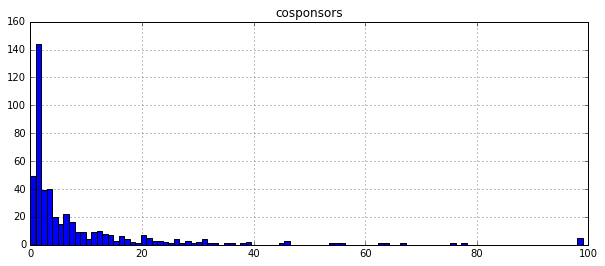

In [5]:
df_activebills.hist("cosponsors", bins = 100, figsize = [10, 4])

We notice a few things in this graphic.  

* Many bills (perhaps most) have 0-1 cosponsors.
* There's an odd uptick at 99 -- there are a few bills that seem to have universal agreement.
* There are a lot of "ties" of bills with the same number of sponsors.

It seems that ranking bills by number of senator cosponsorships alone (degree centrality) may not provide a lot of information.  We will want to get the relative importance of senators first, then include that in ranking the centrality of bills in a custom measure of centrality.

## Create a Graph of Senators and Bills Using NetworkX

First, we'll simplify our Senators and Bills data!

### Simplify Senators

In [6]:
simplifiedSenators = [dict.fromkeys(["id", "first_name", "middle_name", "last_name", "party", \
                                     "seniority", "state_rank", "facebook_account", "twitter_account"])]

for senator in senators:
    simplifiedSenator = {key: senator[key] for key in senator if key in \
                      ['id','first_name','middle_name','last_name','party',\
                       'seniority','state_rank', "facebook_account", "twitter_account"]}
    simplifiedSenators.append(simplifiedSenator)

### Remove "None" row
There'a a "none" first row that is going to cause a problem. I'll remove it.

In [7]:
simplifiedSenators.pop(0)
dfSenators = pd.DataFrame(simplifiedSenators).set_index('id')
dfSenators.head()

,facebook_account,first_name,last_name,middle_name,party,seniority,state_rank,twitter_account
id,,,,,,,,
A000360,senatorlamaralexander,Lamar,Alexander,None,R,15,senior,SenAlexander
B001230,TammyBaldwin,Tammy,Baldwin,None,D,5,junior,SenatorBaldwin
B001261,johnbarrasso,John,Barrasso,None,R,11,junior,SenJohnBarrasso
B001267,senbennetco,Michael,Bennet,None,D,9,senior,SenBennetCo
B001277,SenBlumenthal,Richard,Blumenthal,None,D,7,senior,SenBlumenthal


### Simplify Bills, Remove "None" Row

In [8]:
simplifiedBills = [dict.fromkeys(['bill_slug','title','sponsor_id','primary_subject','sponsor_party'])]
for activeBill in activeBills:
    simplifiedBill = {key: activeBill[key] for key in activeBill if key in \
                      ['bill_slug','title', 'sponsor_id','primary_subject','sponsor_party']}
    simplifiedBills.append(simplifiedBill)
simplifiedBills.pop(0)
dfBills = pd.DataFrame(simplifiedBills).set_index('bill_slug')
dfBills.head()

,primary_subject,sponsor_id,sponsor_party,title
bill_slug,,,,
sres357,,M001176,D,A resolution expressing the sense of the Senat...
sres358,Health,I000055,R,"A resolution designating December 3, 2017, as ..."
s447,International Affairs,B001230,D,A bill to require reporting on acts of certain...
sres356,Congress,K000393,R,A resolution expressing the sense of the Senat...
sres351,,W000437,R,A resolution recognizing the bicentennial of t...


Now we have simplified data that's nice and clean.  Let's create a graph that links senators to the bills they sponsored.

In [9]:
g = net.Graph()
for senator in simplifiedSenators:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(senator['id'], attr_dict=senator, bipartite=0)  
for bill in simplifiedBills:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(bill['bill_slug'], attr_dict=bill, bipartite = 1)
        # we removed some senators so only add edges to folks who are still senators!
    if bill['sponsor_id'] in g:
        g.add_edge(bill['sponsor_id'],bill['bill_slug'])

### Get Bill Cosponsors

Bills also have cosponsors, in some cases, so we should have those links in place as well! 

#### Get Cosponsored Bills

In [10]:
df_activeBills = pd.DataFrame(activeBills)
cosponsoredBills = df_activeBills
cosponsoredBills = cosponsoredBills[['bill_slug','sponsor_id', 'cosponsors']]
cosponsoredBills.head()

,bill_slug,sponsor_id,cosponsors
0,sres357,M001176,26
1,sres358,I000055,1
2,s447,B001230,21
3,sres356,K000393,1
4,sres351,W000437,1


### Create Edges for Cosponsorship

In [11]:
g = net.Graph()
for senator in simplifiedSenators:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(senator['id'], attr_dict=senator, bipartite=0)  
for bill in simplifiedBills:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(bill['bill_slug'], attr_dict=bill, bipartite = 1)
    # we removed some senators so only add edges to folks who are still senators!
    if bill['sponsor_id'] in g:
        g.add_edge(bill['sponsor_id'],bill['bill_slug'])

What we've done above is address primary sponsorship.  Now we have to look up the info on each cosponsored bill (at least the ones that have at least one cosponsor), collect all the cosponsors of that bill and link cosponsors to the bills they cosponsored with edges.

In [12]:
for index, row in cosponsoredBills[(cosponsoredBills['cosponsors'] > 0)].iterrows():
    cosponsorInfo = pd.DataFrame(propublica("https://api.propublica.org/congress/v1/115/bills/" + \
                                            row['bill_slug'] + "/cosponsors.json")\
                                            ['results'][0]['cosponsors'])
    for cosponsor in cosponsorInfo['cosponsor_id']: # for each cosponsor
        # we removed some senators so only add edges to folks who are still senators!
        if cosponsor in g:
            g.add_edge(cosponsor,row['bill_slug'], bipartite=1) # link cosponsoring Senator to the bill

## Graph attractively
First we want to make sure that senators and bills are separate node lists, so we can plot them in different colors. We'll make the node size dependent on the degree of each node!

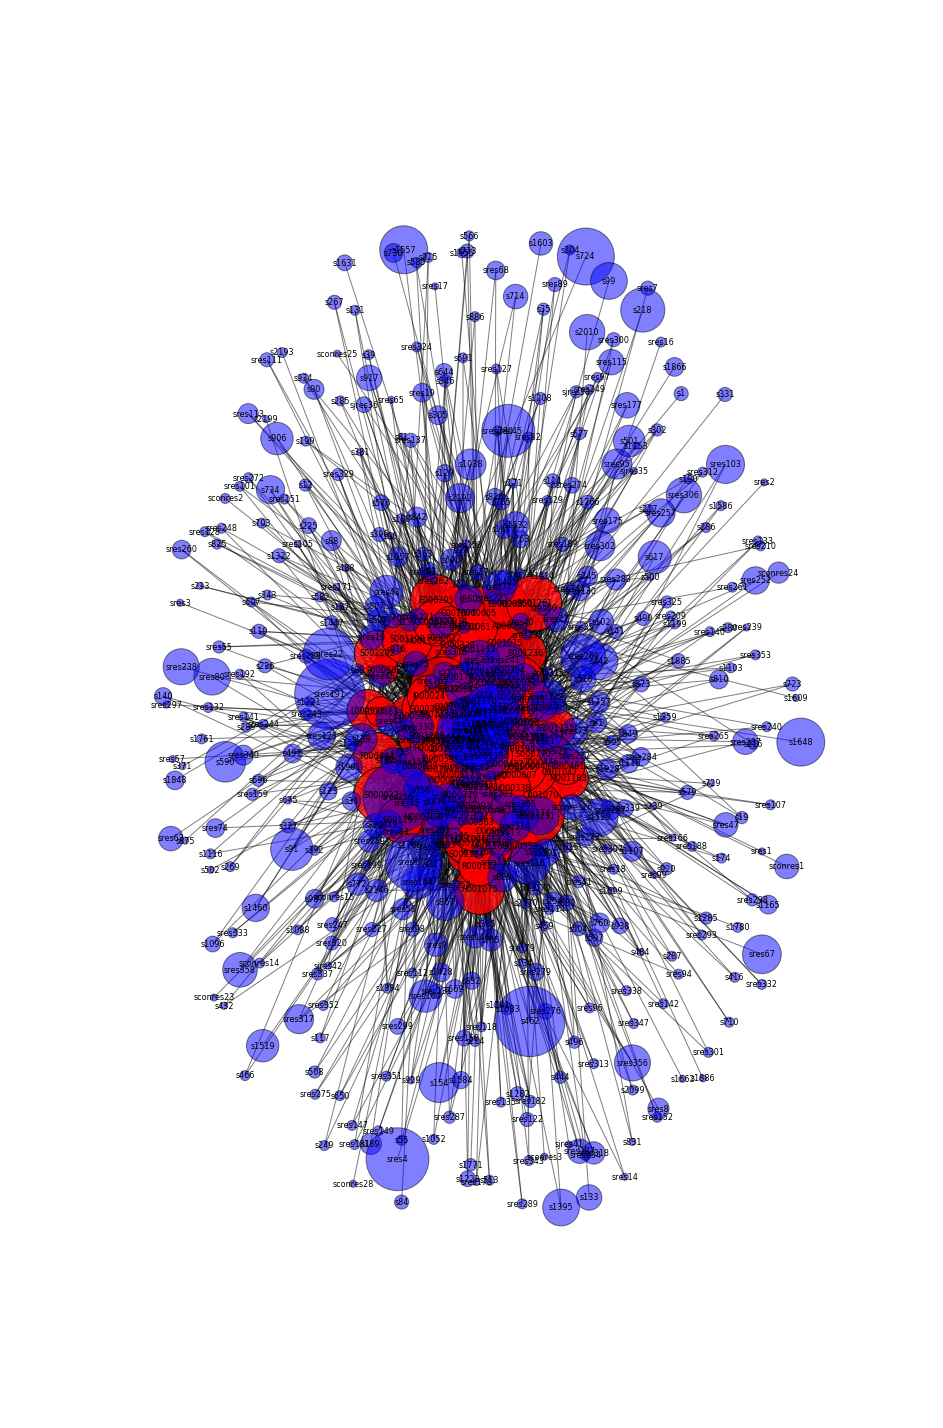

In [13]:
senators, bills = bipartite.sets(g)
import matplotlib.pyplot as plt
%matplotlib inline

pos=net.spring_layout(g, k=0.4) # positions for all nodes, nicely spread apart.

# calculate degree centrality
senatorDegree = net.degree(g, senators) 
billDegree = net.degree(g, bills)

plt.figure(1,figsize=(16,25)) 

# nodes
net.draw_networkx_nodes(g,pos,
                       nodelist=senators,
                       node_color='r',
                       node_size=[v * 50 for v in senatorDegree.values()],
                   alpha=0.8)
net.draw_networkx_nodes(g,pos,
                       nodelist=bills,
                       node_color='b',
                       node_size=[v * 50 for v in billDegree.values()],
                   alpha=0.5)

# edges
net.draw_networkx_edges(g,pos,width=1.0,alpha=0.5)
net.draw_networkx_labels(g,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
plt.show() # display

Wow, that's really complex!  Let's project all of that onto senators in order to simplify matters.  We're going to choose eigenvector centrality, because there are bills that every senator sponsored, so degree centrality would give the same measure for each senator, since every senator is linked to every other senator.  This also means that a graph will be very cluttered looking -- everyone connects to everyone else.  We can skip the graph visualization for this reason.  We will, however, plot a histogram of the eigencentrality calculation to see the distribution of senate centrality.

(array([  1.,   1.,   4.,   1.,   4.,   3.,   3.,   4.,   4.,   9.,   6.,
          6.,   9.,   5.,   4.,  12.,   6.,   4.,   3.,   4.,   1.,   1.,
          1.,   2.,   1.]),
 array([ 0.04994687,  0.05389006,  0.05783325,  0.06177643,  0.06571962,
         0.06966281,  0.073606  ,  0.07754919,  0.08149238,  0.08543557,
         0.08937876,  0.09332195,  0.09726514,  0.10120833,  0.10515152,
         0.10909471,  0.1130379 ,  0.11698109,  0.12092428,  0.12486747,
         0.12881066,  0.13275384,  0.13669703,  0.14064022,  0.14458341,
         0.1485266 ]),
 <a list of 25 Patch objects>)

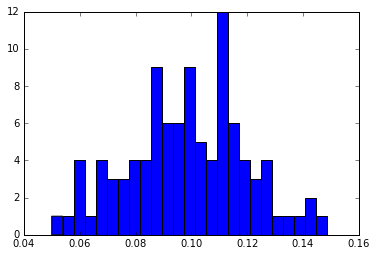

In [14]:
s = bipartite.weighted_projected_graph(g, senators)
senate_eigen_centrality = net.eigenvector_centrality(s, weight='weight')
plt.hist( senate_eigen_centrality.values(), bins=25)

Great, we have some clearly less central senators and some highly central senators, and a bunch in the middle -- the graph looks roughly normal.  We now have measures for senators, which we can rank in terms of centrality.  We can also use this centrality measure to assist in calculating centrality for bills!  Bills that are cosponsored by relatively weakly central senators will not rank as highly as bills that are cosponsored by strongly central senators.

What is the ranking of our Senators?

In [15]:
dfSenators = pd.concat([dfSenators, pd.Series(senate_eigen_centrality, name="centrality")], axis=1)
dfSenators['centrality_rank'] = dfSenators['centrality'].rank(ascending=0)

## Most Central Senators

In [16]:
dfSenators.sort_values('centrality_rank').head(10)

,facebook_account,first_name,last_name,middle_name,party,seniority,state_rank,twitter_account,centrality,centrality_rank
C001088,senatorchriscoons,Christopher,Coons,A.,D,9,junior,SenCoonsOffice,0.148527,1
R000595,SenatorMarcoRubio,Marco,Rubio,None,R,7,junior,SenRubioPress,0.143113,2
B001277,SenBlumenthal,Richard,Blumenthal,None,D,7,senior,SenBlumenthal,0.142907,3
K000367,None,Amy,Klobuchar,None,D,11,senior,None,0.138463,4
F000062,senatorfeinstein,Dianne,Feinstein,None,D,25,senior,SenFeinstein,0.136126,5
D000563,SenatorDurbin,Richard,Durbin,J.,D,21,senior,SenatorDurbin,0.129446,6
C001035,susancollins,Susan,Collins,None,R,21,senior,SenatorCollins,0.127740,7
N000032,None,Bill,Nelson,None,D,17,senior,SenBillNelson,0.126545,8
S001181,SenatorShaheen,Jeanne,Shaheen,None,D,9,senior,SenatorShaheen,0.126233,9
C001070,SenatorBobCasey,Bob,Casey,None,D,11,senior,SenBobCasey,0.125665,10


## Least Central Senators

In [17]:
dfSenators.sort_values('centrality_rank').tail(10)

,facebook_account,first_name,last_name,middle_name,party,seniority,state_rank,twitter_account,centrality,centrality_rank
S001194,SenBrianSchatz,Brian,Schatz,None,D,5,senior,SenBrianSchatz,0.068409,90
M001169,chrismurphyct,Christopher,Murphy,S.,D,5,junior,ChrisMurphyCT,0.068304,91
A000360,senatorlamaralexander,Lamar,Alexander,None,R,15,senior,SenAlexander,0.068255,92
S000033,senatorsanders,Bernard,Sanders,None,I,11,junior,SenSanders,0.062402,93
M000355,mitchmcconnell,Mitch,McConnell,None,R,33,senior,McConnellPress,0.061343,94
C001071,bobcorker,Bob,Corker,None,R,11,junior,SenBobCorker,0.060805,95
L000577,senatormikelee,Mike,Lee,None,R,7,junior,SenMikeLee,0.060260,96
S001197,SenatorSasse,Ben,Sasse,None,R,3,junior,SenSasse,0.058465,97
S000320,RichardShelby,Richard,Shelby,C.,R,31,senior,SenShelby,0.056242,98
P000603,SenatorRandPaul,Rand,Paul,None,R,7,junior,None,0.049947,99


For each bill, we'll take the centrality of each senator it's attached to, and come up with a sum.  That will be the centrality measure for our bills!  While we're at it, we'll also measure the partisan influence of each bill.

In [18]:
bill_centrality = {}
republican_support = {}
democratic_support = {}
partisan_strength = {}
for b in bills:
    centrality = 0
    r_support = 0
    d_support = 0
    for senator in g.neighbors(b):
        centrality += senate_eigen_centrality[senator]
        bill_centrality[b] = centrality
        if g.node[senator]['party'] == 'R' :
            r_support += 1
        if g.node[senator]['party'] == 'D' :
            d_support += 1
    bill_centrality[b] = centrality
    republican_support[b] = r_support
    democratic_support[b] = d_support
    partisan = (r_support - d_support)/(r_support + d_support)
    partisan_strength[b] = partisan

## Take a look at partisan strength of bills

Strongly democratic bills are to the left (get it?) while strongly republican bills are to the right.

(array([  47.,    1.,    4.,    8.,    7.,   13.,   11.,    9.,   29.,
          12.,   26.,    7.,  124.,   15.,   15.,   10.,   26.,    5.,
           9.,    3.,    1.,    2.,    0.,    2.,   87.]),
 array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
        -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
         0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ]),
 <a list of 25 Patch objects>)

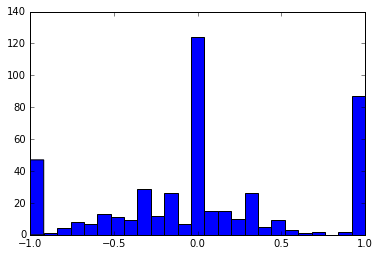

In [19]:
plt.hist(partisan_strength.values(), bins=25)

What are the most highly republican-supported bills?

In [20]:
dfBills['partisan'] = pd.Series(partisan_strength)
dfBills['partisan_rank'] = dfBills['partisan'].rank(ascending=0)

In [21]:
dfBills.sort_values('partisan_rank').head(20)

,primary_subject,sponsor_id,sponsor_party,title,partisan,partisan_rank
bill_slug,,,,,,
sres1,Congress,M000355,R,A resolution informing the President of the Un...,1,44
s723,Energy,B001135,R,A bill to extend the deadline for commencement...,1,44
s724,Energy,M001153,R,A bill to amend the Federal Power Act to moder...,1,44
s590,Public Lands and Natural Resources,R000584,R,A bill to authorize the Secretary of Agricultu...,1,44
s1866,Education,A000360,R,A bill to provide the Secretary of Education w...,1,44
s218,Government Operations and Politics,G000562,R,A bill to restrict the inclusion of social sec...,1,44
s1894,Transportation and Public Works,M000303,R,A bill to exempt Puerto Rico from the coastwis...,1,44
s34,Government Operations and Politics,J000293,R,"A bill to amend chapter 8 of title 5, United S...",1,44
s644,Public Lands and Natural Resources,C000567,R,A bill to authorize the Secretary of the Inter...,1,44


What are the most democratic-leaning bills?

In [22]:
dfBills.sort_values('partisan_rank').tail(20)

,primary_subject,sponsor_id,sponsor_party,title,partisan,partisan_rank
bill_slug,,,,,,
s729,Public Lands and Natural Resources,H001075,D,A bill to authorize the Secretary of the Inter...,-1,454
s617,Public Lands and Natural Resources,M001169,D,A bill to amend the Wild and Scenic Rivers Act...,-1,454
sres147,"Civil Rights and Liberties, Minority Issues",F000062,D,A resolution commemorating the 25th anniversar...,-1,454
sres318,Sports and Recreation,W000779,D,A resolution honoring the Portland Thorns FC a...,-1,454
s513,Public Lands and Natural Resources,W000779,D,A bill to designate the Frank and Jeanne Moore...,-1,454
s502,Public Lands and Natural Resources,F000457,D,A bill to modify the boundary of Voyageurs Nat...,-1,454
s675,Environmental Protection,G000555,D,A bill to amend and reauthorize certain provis...,-1,454
sres275,Education,D000622,D,A resolution congratulating Northeastern Illin...,-1,454
sjres22,Transportation and Public Works,K000384,D,A joint resolution granting the consent and ap...,-1,454


## Bill Centrality Ranks

Let's take a look at the centrality of the first, say, 15 bills, to get an idea of our measures.

In [23]:
bill_centrality.items()[1:15]

[(u'sres57', 0.06134254081851406),
 (u'sres55', 0.3171560153872613),
 (u'sres132', 0.2169226787139762),
 (u'sres133', 0.1831238216820144),
 (u'sres130', 0.8628497720264807),
 (u'sres131', 0.43766387890172265),
 (u'sres137', 0.42513829636447775),
 (u'sres135', 0.2043584470856269),
 (u'sres139', 3.493413541446727),
 (u's304', 0.2106790095157134),
 (u's204', 4.3598537421957655),
 (u's55', 0.1846436358191772),
 (u'sres27', 1.352943579180755),
 (u'sres26', 2.042463704234362)]

## Most Central Bills

Let's rank these bills and see what the most central bills are.

In [24]:
dfBills['centrality'] = pd.Series(bill_centrality)
dfBills['centrality_rank'] = dfBills['centrality'].rank(ascending=0)
dfBills.sort_values('centrality_rank').head(20)

,primary_subject,sponsor_id,sponsor_party,title,partisan,partisan_rank,centrality,centrality_rank
bill_slug,,,,,,,,
sres184,Congress,M000355,R,A resolution relative to the death of James Pa...,0.072165,172.0,9.733464,2.5
sres292,Crime and Law Enforcement,H001041,R,A resolution condemning the brutal and sensele...,0.072165,172.0,9.733464,2.5
s1616,Congress,R000307,R,A bill to award the Congressional Gold Medal t...,0.072165,172.0,9.733464,2.5
sres193,Congress,K000384,D,A resolution commending the bravery of the Uni...,0.072165,172.0,9.733464,2.5
sres254,Congress,M000355,R,"A resolution relative to the death of Pietro ""...",0.072165,172.0,9.733464,5.0
s1182,Finance and Financial Sector,Y000064,R,A bill to require the Secretary of the Treasur...,-0.027027,303.0,7.949965,6.0
sres6,International Affairs,R000595,R,A resolution objecting to United Nations Secur...,0.230769,138.0,7.896467,7.0
sres173,Crime and Law Enforcement,G000386,R,A resolution designating the week of May 15 th...,0.212121,140.0,6.903245,8.0
s1598,Armed Forces and National Security,I000055,R,"A bill to amend title 38, United States Code, ...",-0.142857,315.5,6.756279,9.0


## Least Central Bills

And the least central?

In [25]:
dfBills.sort_values('centrality_rank').tail(20)

,primary_subject,sponsor_id,sponsor_party,title,partisan,partisan_rank,centrality,centrality_rank
bill_slug,,,,,,,,
s133,Armed Forces and National Security,B001135,R,A bill to authorize appropriations for fiscal ...,1,44,0.068981,457.0
s99,Public Lands and Natural Resources,A000360,R,A bill to require the Secretary of the Interio...,1,44,0.068255,460.0
s1866,Education,A000360,R,A bill to provide the Secretary of Education w...,1,44,0.068255,460.0
s1609,Economics and Public Finance,A000360,R,An original bill making appropriations for ene...,1,44,0.068255,460.0
sres1,Congress,M000355,R,A resolution informing the President of the Un...,1,44,0.061343,466.5
sconres24,Economics and Public Finance,M000355,R,Providing for a correction in the enrollment o...,1,44,0.061343,466.5
sres16,Congress,M000355,R,A resolution to constitute the majority party'...,1,44,0.061343,466.5
sres2,Congress,M000355,R,A resolution informing the House of Representa...,1,44,0.061343,466.5
sres57,Congress,M000355,R,A resolution to constitute the majority party'...,1,44,0.061343,466.5
